
🔍 Random Forest
  MAE: 29.3256
  R²:  -0.2658


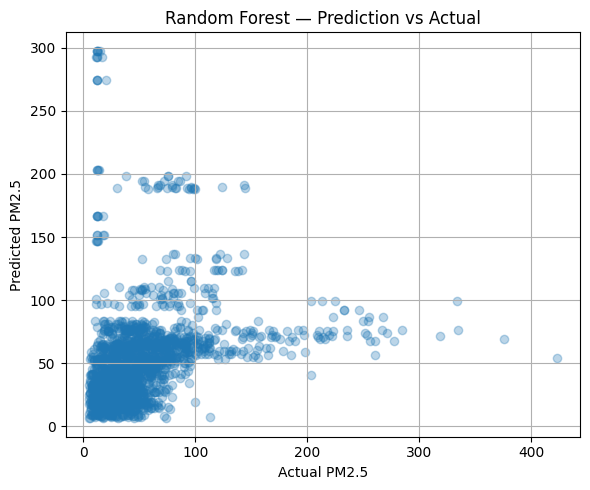


🔍 XGBoost
  MAE: 29.2428
  R²:  -0.0812


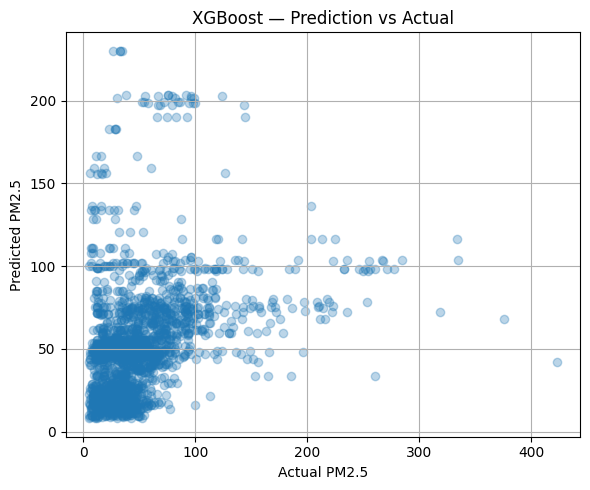


🔍 CatBoost
  MAE: 28.1347
  R²:  -0.1061


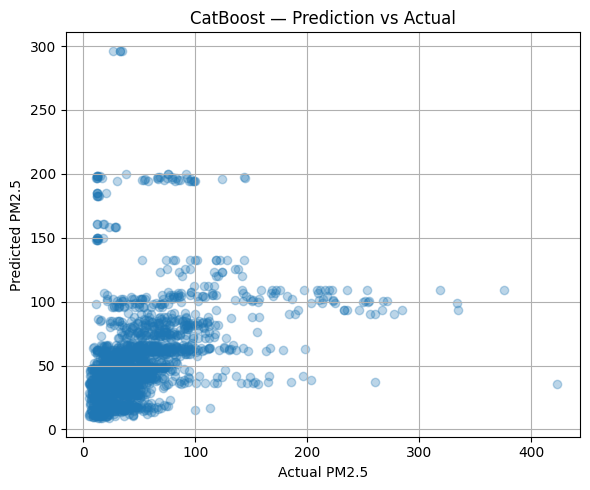

/run/media/beech/8bd9d608-9710-45e6-8600-71345a83e11e/home/potato-machine/Documents/hello snitch/PM-conc/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


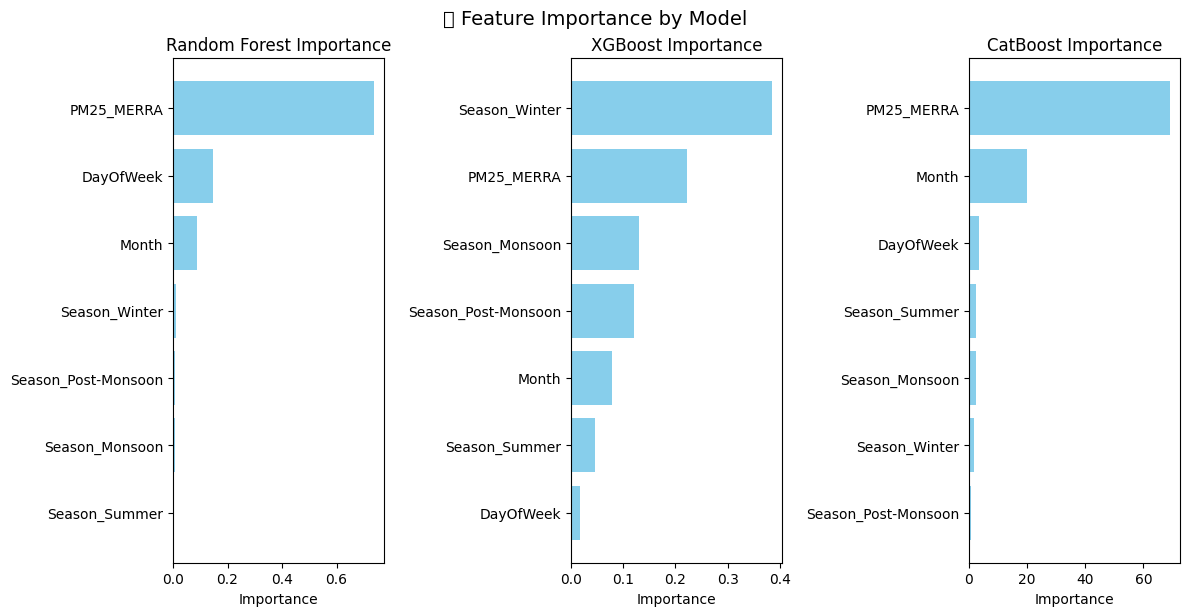

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Load dataset
data = pd.read_csv("datasets/cpcb+merra_processed/merged_model_input_monthly.csv", parse_dates=["date"])

# ========== Feature Engineering ==========
data['DayOfWeek'] = data['date'].dt.dayofweek
data['Month'] = data['date'].dt.month

def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Summer'
    elif month in [6, 7, 8]: return 'Monsoon'
    else: return 'Post-Monsoon'

data['Season'] = data['Month'].apply(get_season)
data = pd.get_dummies(data, columns=['Season'])

# ========== Features and Targets ==========
features = ['DayOfWeek', 'Month', 'PM25_MERRA']
features += [col for col in data.columns if col.startswith('Season_')]

X = data[features]
y = data['PM2.5']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ========== Model Comparison Setup ==========
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(n_estimators=100, random_state=42, verbose=0)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "R²": r2}

    print(f"\n🔍 {name}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²:  {r2:.4f}")

    # Optional: Save plot
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.xlabel("Actual PM2.5")
    plt.ylabel("Predicted PM2.5")
    plt.title(f"{name} — Prediction vs Actual")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# ========== Feature Importance Plot ==========
importances_dict = {}

for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        importances_dict[name] = importances
    else:
        print(f"⚠️ {name} does not support feature importances")

# Plot all importances side by side
plt.figure(figsize=(12, 6))

for i, (name, importances) in enumerate(importances_dict.items(), 1):
    sorted_idx = np.argsort(importances)[::-1]
    sorted_feats = np.array(features)[sorted_idx]
    sorted_importances = importances[sorted_idx]

    plt.subplot(1, 3, i)
    plt.barh(sorted_feats[::-1], sorted_importances[::-1], color="skyblue")
    plt.title(f"{name} Importance")
    plt.xlabel("Importance")
    plt.tight_layout()

plt.suptitle("🔎 Feature Importance by Model", fontsize=14, y=1.02)
plt.show()
